In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import os
import sys
sys.path.insert(0, os.path.dirname(os.getcwd()))

import helper_functions as functions
import MS_functions
import MS_similarity_classical as MS_sim_classic

In [13]:
# Locations (import paths from config.py)
from config import ROOT, PATH_SPEC2VEC, PATH_MS_DATA, PATH_SAVE_MODEL, PATH_COMPUTED, PATH_OUTPUT

## Import uniqueInchikey subset (positive ionization mode)

# 1. Import and filter MS-MS data from MGF file (positive ionization mode)

### Loading MGF file
In the following the MGF file containing all spectra and metadata will be loaded. 
The MGF file was generated from all publich gnps libraries (state: 26 July 2019). Spectra annotations were checked, cleaned, and extended where possible following a procedure described in another notebook: https://github.com/iomega/Spec2Vec/blob/master/notebooks/Spec2Vec_01_MGF_from_gnps_library_search.ipynb  

### Spectra filtering
**1. Discard spectra with too few peaks.**  
Spectra with less than "min_peaks" peaks will be ignored. Here this is set to min_peaks = 10.  

**2. Filter out noise.**  
Further filtering is done to reduce the level of noise in the spectra. 
Here this is simply done by a relative intensity threshols. All peaks with intensities < maximum peak intensity will be discarded. 

Past alternative:
For this we calculate a threshold (or minimum peak intensity) for every spectrum. Where possible (most cases), this threshold is calculated by doing an exponential fit to the peak intensity histogram ("exp_intensity_filter"). If that fails we take the mean intensity of all peaks but the highest as a threshold.  

**3. But keep at least min_peaks peaks.**  
The filtering step will NOT discard any of the min_peaks highest peaks (even if those happen to be below the threshold), to guarantee that every spectra will at least have min_peaks peaks.

### Creation of documents from spectra
Peaks and losses (= precursor mass - peak mass) are converted into words using a precision of "num_decimals".  
A peak with m/z = 108.3643 will hence become a string: "peak_108.36".  
A loss with m/z = 64.2257 will hence become a string: "loss_64.23".  
All words of one spectrum are collected in one list which represents the entire spectrum as a 'document'.

In [4]:
file_json = os.path.join(PATH_MS_DATA, "uniqueInchikey_positive_minpeaks_10_2dec_minperc05_191109.json")
file_mgf = os.path.join(PATH_MS_DATA, "allGNPS_positive_uniqueInchikey_191107.mgf")

spectra, spectra_dict, MS_documents, MS_documents_intensity, spectra_metadata = MS_functions.load_MGF_data(file_mgf = file_mgf,
                                                           file_json = file_json,
                                                           num_decimals = 2,
                                                           min_frag = 0.0, max_frag = 1000.0,
                                                           min_loss = 5.0, max_loss = 500.0,
                                                           min_intensity_perc = 0.5,
                                                           exp_intensity_filter = None, #0.2,
                                                           min_keep_peaks_0 = 200, #10,
                                                           min_keep_peaks_per_mz = 0, #20/200,
                                                           min_peaks = 10,
                                                           max_peaks = None,
                                                           peak_loss_words = ['peak_', 'loss_'])

Spectra json file found and loaded.


In [5]:
print("Number of imported spectra:", len(spectra))

Number of imported spectra: 10998


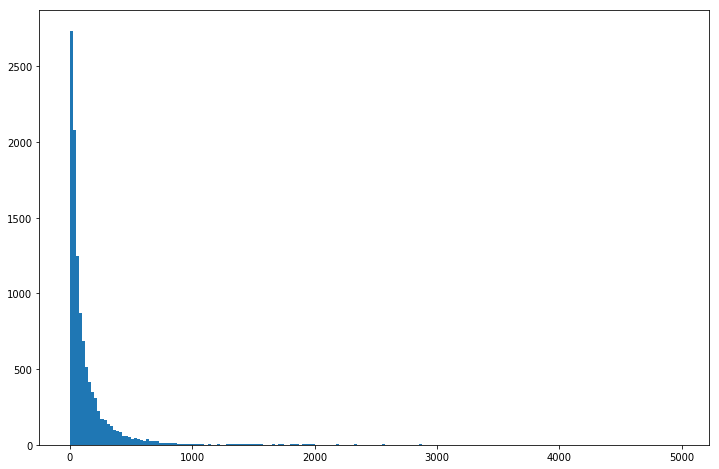

In [5]:
num_peaks = []
for spec in spectra:
    num_peaks.append(spec.n_peaks)
    
from matplotlib import pyplot as plt
plt.figure(figsize=(12,8))
a = plt.hist(num_peaks, np.arange(0,5000,25))

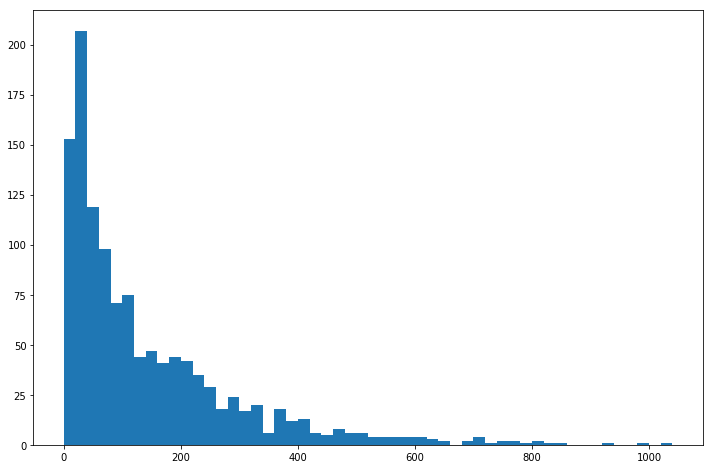

In [6]:
pepmasses = []
for spec in spectra:
    pepmasses.append(spec.precursor_mz)
    
plt.figure(figsize=(12,8))
a = plt.hist(np.array(num_peaks)[np.where(np.array(pepmasses)> 700)], np.arange(0,1050,20))

# 2. Calculate modified cosine scores for all-vs all spectra

In [9]:
import MS_similarity_classical as MS_sim_classic

filename = os.path.join(PATH_COMPUTED, 'modcos_scores_191203_uniqueInchikey_pos_minperc05_tol0005.npy')
M_modcos_sim_greedy, M_modcos_matches_greedy = MS_sim_classic.cosine_score_matrix(spectra, 
                  tol = 0.005,
                  max_mz = 1000.0, 
                  min_intens = 0,
                  mass_shifting = True,
                  method='greedy-numba', 
                  num_workers = 4,
                  filename = filename,
                  safety_points = 25)

Could not find file  C:\OneDrive - Netherlands eScience Center\Project_Wageningen_iOMEGA\Spec2Vec\computed_results\modcos_scores_191203_uniqueInchikey_pos_minperc05_tol0005.npy
Modified cosine scores will be calculated from scratch.
Calculate pairwise scores by  4 number of workers.


  Calculated MolNet for pair  678 -- 10536 . (  11.97  % done).% done). (  0.07  % done). 0.08  % done). Calculated MolNet for pair  12 -- 9101 . (  0.23  % done).0.27  % done).. (  0.36  % done).20 -- 1249 . (  0.37  % done). . (  0.37  % done). 0.38  % done). Calculated MolNet for pair  21 -- 272 . (  0.38  % done).-- 5296 . (  0.41  % done).. (  0.41  % done).23 -- 3321 . (  0.42  % done). Calculated MolNet for pair  24 -- 7347 . (  0.45  % done).0.5  % done). Calculated MolNet for pair  29 -- 8492 . (  0.54  % done).9524 . (  0.56  % done).. (  0.59  % done).0.63  % done).  % done). 4899 . (  0.73  % done).  % done). Calculated MolNet for pair  41 -- 8942 . (  0.76  % done). 8986 . (  0.78  % done).-- 9124 . (  0.83  % done). 4172 . (  0.84  % done).-- 9172 . (  0.85  % done).4427 . (  0.93  % done). Calculated MolNet for pair  53 -- 4536 . (  0.97  % done).-- 8536 . (  0.98  % done). 9592 . (  1.0  % done).. (  1.03  % done). % done). 57 -- 9766 . (  1.05  % done). Calculated MolN

  Calculated MolNet for pair  1969 -- 2402 . (  32.6  % done)... 1237 -- 9176 . (  21.24  % done).21.27  % done).21.27  % done).. (  21.31  % done). 8631 . (  21.34  % done). -- 6877 . (  21.35  % done).  % done).1248 -- 2871 . (  21.41  % done).1250 -- 7374 . (  21.45  % done). . (  21.5  % done).-- 4907 . (  21.54  % done).1258 -- 8426 . (  21.58  % done).. (  21.59  % done).21.65  % done).1264 -- 3007 . (  21.67  % done).-- 5274 . (  21.69  % done). % done).-- 4081 . (  21.74  % done). 6081 . (  21.74  % done).-- 9081 . (  21.74  % done).-- 8352 . (  21.76  % done).1272 -- 9171 . (  21.81  % done).4399 . (  21.93  % done). Calculated MolNet for pair  1285 -- 7824 . (  22.01  % done).1286 -- 8112 . (  22.03  % done). 9112 . (  22.03  % done). 1288 -- 8691 . (  22.06  % done). 1289 -- 3982 . (  22.07  % done). -- 9274 . (  22.1  % done).6567 . (  22.11  % done).. (  22.13  % done). 1293 -- 5156 . (  22.14  % done). % done). . (  22.21  % done). Calculated MolNet for pair  1304 -- 8467

  Calculated MolNet for pair  2720 -- 4999 . (  43.35  % done)..-- 4347 . (  32.64  % done).1971 -- 9347 . (  32.64  % done).4296 . (  32.67  % done). 9186 . (  32.75  % done).-- 5167 . (  32.76  % done).1981 -- 4132 . (  32.79  % done).. (  32.79  % done).5101 . (  32.82  % done). 4087 . (  32.83  % done).9087 . (  32.84  % done). . (  32.89  % done). 6041 . (  32.89  % done). Calculated MolNet for pair  1998 -- 3996 . (  33.04  % done).. (  33.05  % done).3997 . (  33.05  % done).. (  33.07  % done).5999 . (  33.07  % done). 33.16  % done).7032 . (  33.16  % done).2006 -- 9032 . (  33.17  % done).. (  33.2  % done).2017 -- 9186 . (  33.33  % done).2036 -- 6737 . (  33.61  % done). Calculated MolNet for pair  2036 -- 8737 . (  33.61  % done). 6776 . (  33.62  % done).-- 8776 . (  33.63  % done).. (  33.66  % done).2041 -- 8942 . (  33.68  % done).. (  33.7  % done). Calculated MolNet for pair  2043 -- 9031 . (  33.71  % done). -- 4077 . (  33.72  % done). 33.72  % done). 2044 -- 9077 

  Calculated MolNet for pair  3835 -- 8199 . (  57.59  % done)..- 10149 . (  46.33  % done).2720 -- 8999 . (  43.36  % done). 2727 -- 9081 . (  43.46  % done).6007 . (  43.51  % done).43.52  % done).2739 -- 9907 . (  43.62  % done). -- 4871 . (  43.72  % done).-- 5877 . (  43.78  % done).43.84  % done). 2763 -- 8991 . (  43.95  % done).-- 4757 . (  43.95  % done). 2775 -- 9249 . (  44.11  % done).4716 . (  44.2  % done). % done). 9606 . (  44.48  % done). . (  44.55  % done).. (  44.56  % done).-- 5547 . (  44.77  % done). Calculated MolNet for pair  2827 -- 9031 . (  44.81  % done).44.88  % done).  % done). % done). Calculated MolNet for pair  2841 -- 8742 . (  45.0  % done).2848 -- 6671 . (  45.09  % done). Calculated MolNet for pair  2849 -- 7522 . (  45.11  % done). 5227 . (  45.13  % done). Calculated MolNet for pair  2854 -- 9792 . (  45.18  % done). 45.2  % done). 7366 . (  45.22  % done).-- 8366 . (  45.22  % done). Calculated MolNet for pair  2865 -- 4274 . (  45.32  % done). 

  Calculated MolNet for pair  4814 -- 9332 . (  68.4  % done)....66.97  % done). . (  57.62  % done).3839 -- 5557 . (  57.63  % done). Calculated MolNet for pair  3840 -- 9399 . (  57.65  % done). 3842 -- 10086 . (  57.68  % done). 8472 . (  57.72  % done).3854 -- 10292 . (  57.82  % done).. (  57.85  % done). Calculated MolNet for pair  3857 -- 10866 . (  57.86  % done). . (  57.86  % done). -- 7587 . (  57.87  % done). % done). Calculated MolNet for pair  3864 -- 10907 . (  57.94  % done).58.02  % done). 58.05  % done). 7499 . (  58.06  % done).-- 9256 . (  58.09  % done). . (  58.1  % done).7666 . (  58.15  % done).-- 8666 . (  58.15  % done). . (  58.2  % done).58.24  % done).-- 9561 . (  58.27  % done). 3894 -- 9352 . (  58.29  % done). Calculated MolNet for pair  3896 -- 9147 . (  58.31  % done). 58.46  % done).. (  58.49  % done). . (  58.55  % done). 10317 . (  58.55  % done). Calculated MolNet for pair  3917 -- 5236 . (  58.55  % done).-- 5552 . (  58.66  % done). 3930 -- 9274

  Calculated MolNet for pair  6149 -- 10472. (  80.57  % done)... (  68.44  % done).4820 -- 6249 . (  68.45  % done).4824 -- 10547 . (  68.5  % done). Calculated MolNet for pair  4828 -- 9861 . (  68.54  % done).4832 -- 9191 . (  68.58  % done).4836 -- 6537 . (  68.62  % done). Calculated MolNet for pair  4850 -- 9374 . (  68.76  % done). % done).-- 10541 . (  68.9  % done). Calculated MolNet for pair  4867 -- 9011 . (  68.93  % done).-- 10752 . (  68.96  % done).4870 -- 9624 . (  68.97  % done).9371 . (  68.99  % done).4876 -- 6877 . (  69.02  % done).-- 6636 . (  69.04  % done). % done). 69.12  % done). 9382 . (  69.16  % done). 9852 . (  69.21  % done). 69.21  % done). % done).4897 -- 6546 . (  69.23  % done).4897 -- 8546 . (  69.24  % done). % done). Calculated MolNet for pair  4898 -- 7446 . (  69.25  % done). 9961 . (  69.3  % done). % done).-- 7591 . (  69.34  % done).9501 . (  69.35  % done). 69.35  % done).. (  69.36  % done). -- 9324 . (  69.37  % done).. (  69.39  % done). C

  Calculated MolNet for pair  8189 -- 8332 . (  93.48  % done)..6152 -- 8931 . (  80.59  % done). 6154 -- 9242 . (  80.61  % done). 7927 . (  80.78  % done). 8649 . (  80.82  % done). 6184 -- 9387 . (  80.85  % done).80.96  % done). -- 9096 . (  80.96  % done).6204 -- 8317 . (  81.01  % done). 8151 . (  81.04  % done).6228 -- 7561 . (  81.2  % done).6228 -- 8561 . (  81.2  % done). Calculated MolNet for pair  6230 -- 10024 . (  81.22  % done). Calculated MolNet for pair  6241 -- 8642 . (  81.3  % done). 6242 -- 9886 . (  81.31  % done). % done). 10377 . (  81.33  % done). Calculated MolNet for pair  6256 -- 9407 . (  81.42  % done).. (  81.47  % done). Calculated MolNet for pair  6267 -- 9311 . (  81.51  % done). Calculated MolNet for pair  6273 -- 7946 . (  81.55  % done). . (  81.58  % done).. (  81.59  % done). -- 10182 . (  81.62  % done).7751 . (  81.63  % done). Calculated MolNet for pair  6320 -- 9999 . (  81.92  % done). . (  82.01  % done). 6336 -- 9287 . (  82.04  % done).996

  Calculated MolNet for pair  10966 -- 10992 . (  100.01  % done). done). 8198 -- 10096 . (  93.53  % done).-- 10317 . (  93.56  % done). 8206 -- 9732 . (  93.56  % done). . (  93.62  % done).8224 -- 10647 . (  93.65  % done). 93.66  % done). Calculated MolNet for pair  8245 -- 9624 . (  93.74  % done). Calculated MolNet for pair  8267 -- 10311 . (  93.84  % done). -- 10222 . (  93.88  % done). 8279 -- 9617 . (  93.9  % done).  % done).. (  93.94  % done).-- 10146 . (  93.98  % done). -- 10137 . (  94.04  % done).9322 . (  94.08  % done).8341 -- 9992 . (  94.17  % done). % done).. (  94.22  % done).94.25  % done).8363 -- 9791 . (  94.27  % done).8370 -- 9374 . (  94.3  % done).94.32  % done).-- 9532 . (  94.35  % done).9796 . (  94.42  % done).8402 -- 9806 . (  94.44  % done).. (  94.45  % done). 8410 -- 10074 . (  94.47  % done). % done). 94.55  % done).-- 9957 . (  94.56  % done). 10262 . (  94.57  % done).94.58  % done). 94.62  % done). . (  94.72  % done).94.73  % done).8476 -- 104

In [ ]:
# time-wise: Started 19:03 ... to 2:58 --> 8 hours
# 21:58 --> 5:50

In [11]:
# show number of matched peaks:
M_modcos_matches_greedy[:10,:10]

array([[ 19.,   2.,   0.,   0.,   1.,   3.,   0.,   2.,   1.,   1.],
       [  2., 134.,  49.,   0.,   1.,   2.,  13.,  82.,  50.,  48.],
       [  0.,  49.,  88.,   0.,   1.,   0.,  12.,  54.,  39.,  22.],
       [  0.,   0.,   0.,  18.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  1.,   1.,   1.,   0.,  12.,   0.,   0.,   1.,   0.,   0.],
       [  3.,   2.,   0.,   0.,   0.,  22.,   0.,   1.,   0.,   1.],
       [  0.,  13.,  12.,   0.,   0.,   0.,  24.,  14.,  12.,  10.],
       [  2.,  82.,  54.,   0.,   1.,   1.,  14., 113.,  37.,  35.],
       [  1.,  50.,  39.,   0.,   0.,   0.,  12.,  37.,  80.,  30.],
       [  1.,  48.,  22.,   0.,   0.,   1.,  10.,  35.,  30.,  57.]])

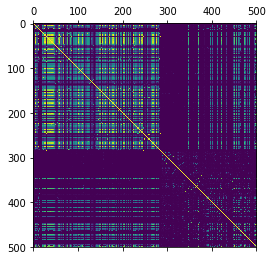

In [12]:
plt.matshow(M_modcos_sim_greedy[:500,:500])

# 3. Compare to molecular similarities based on morgan3 fingerprints
### -->  Load molecular fingerprints

In [21]:
filename = os.path.join(PATH_COMPUTED, 'MS_sim_mol_uniqueInchikey_morgan3_dice2048_191119.npy')
M_sim_mol = MS_sim_classic.mol_sim_matrix([], #fingerprints_morgan3_2048,
                                       [], #fingerprints_morgan3_2048,
                                       method = 'dice',
                                       filename = filename)

Molecular similarity scores found and loaded.


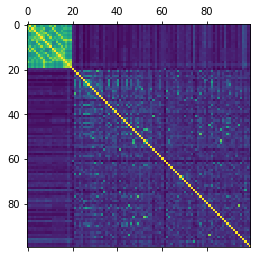

In [22]:
# morgan3_2048_dice
plt.matshow(M_sim_mol[:100,:100])

In [7]:
# Find bette way to keep track of wrong fingerprints!!
exclude_IDs = [1435, 1440, 2232, 2233, 9384, 10791, 10991]

In [23]:
# Transform molecular similarity matrix in 1D array AND remove all excluded IDs
B_morgan3 = np.delete(np.delete(M_sim_mol, exclude_IDs, axis = 0), exclude_IDs, axis = 1)
length = B_morgan3.shape[0]
remove_diagonal = np.array([(i*length + i) for i in range(length)])
B_morgan3 = np.delete(B_morgan3.reshape(length**2), remove_diagonal)

# 4. Compare to molecular similarities based on rdkit fingerprints
### -->  Load molecular fingerprints

In [14]:
filename = os.path.join(PATH_COMPUTED, 'MS_sim_mol_uniqueInchikey_rdkit2048_jaccard_191119.npy')
M_sim_mol = MS_sim_classic.mol_sim_matrix([],
                                       [],
                                       method = 'jaccard',
                                       filename = filename)

Molecular similarity scores found and loaded.


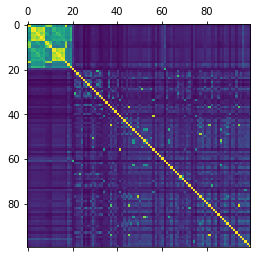

In [15]:
# morgan3_2048_dice
plt.matshow(M_sim_mol[:100,:100])

In [16]:
# Find bette way to keep track of wrong fingerprints!!
exclude_IDs = [1435, 1440, 2232, 2233, 9384, 10791, 10991]

In [17]:
# Transform molecular similarity matrix in 1D array AND remove all excluded IDs
B_rdkit = np.delete(np.delete(M_sim_mol, exclude_IDs, axis = 0), exclude_IDs, axis = 1)
length = B_rdkit.shape[0]
remove_diagonal = np.array([(i*length + i) for i in range(length)])
B_rdkit = np.delete(B_rdkit.reshape(length**2), remove_diagonal)

# 5. Compare classical scores with molecular similarity scores

## Explore the influcence of min_match on mod.cosine score performance:
## 5.1. Mod.cosine score VS morgan3-dice score

In [27]:
num_bins = 1000
show_top_percentile = 0.5

# Loop through different min_matches:
ref_score_cum_collection_morgan3 = []

length = M_sim_mol.shape[0] - len(exclude_IDs)
remove_diagonal = np.array([(i*length + i) for i in range(length)])

B = B_morgan3

N = 19
for i in range(N):
    print("Round", i, "of", N)
    
    M_sim_modcos = M_modcos_sim_greedy * (M_modcos_matches_greedy > i)
    M_sim_modcos = np.delete(np.delete(M_sim_modcos, exclude_IDs, axis = 0), exclude_IDs, axis = 1)
    A = np.delete(M_sim_modcos.reshape(length**2), remove_diagonal)    
    
    # Calculate cumulative distributions
    Asort = np.sort(A)
    starting_point = Asort[int(A.shape[0] - A.shape[0]*show_top_percentile/100)]
    if starting_point == 0:
        print("not enough datapoints != 0 above given top-precentile")
        
    low_As = np.where(A < starting_point)[0]
    A_select = np.delete(A, low_As)
    B_select = np.delete(B, low_As)

    length_selected = A_select.shape[0]
    Data = np.zeros((2, length_selected))
    Data[0,:] = A_select
    Data[1,:] = B_select
    Data = Data[:,np.lexsort((Data[1,:], Data[0,:]))]

    ref_score_cum = []
    
    for i in range(num_bins):
        low = int(i * length_selected/num_bins)
        high = int((i+1) * length_selected/num_bins)
        ref_score_cum.append(np.mean(Data[1,low:]))

    ref_score_cum_collection_morgan3.append(np.array(ref_score_cum))

Round 0 of 19
Round 1 of 19
Round 2 of 19
Round 3 of 19
Round 4 of 19
Round 5 of 19
Round 6 of 19
Round 7 of 19
Round 8 of 19
Round 9 of 19
Round 10 of 19
Round 11 of 19
Round 12 of 19
Round 13 of 19
Round 14 of 19
Round 15 of 19
Round 16 of 19
Round 17 of 19
Round 18 of 19


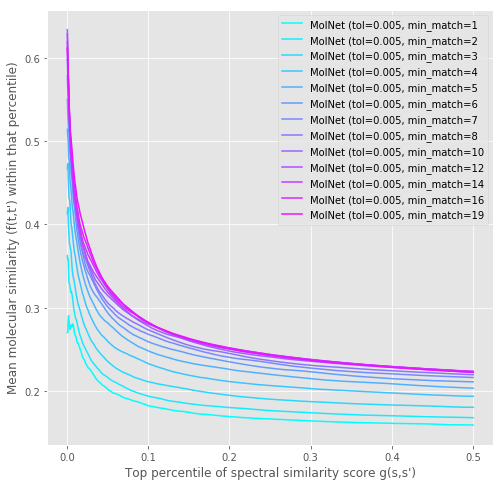

In [29]:
# Compare selection:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(8,8))
cmap = matplotlib.cm.get_cmap('cool') #('plasma') #('Spectral')

selection = [0,1,2,3,4,5,6,7,9,11,13,15,18]
N = len(selection)
for i, select in enumerate(selection):
    ref_score_cum = ref_score_cum_collection_morgan3[select]
    plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_cum, 
             color=cmap(i/N), #color_sequence[i], 
             label="MolNet (tol=0.005, min_match="+str(select+1))

plt.legend()
plt.xlabel("Top percentile of spectral similarity score g(s,s')")
plt.ylabel("Mean molecular similarity (f(t,t') within that percentile)")
plt.savefig('Modcosine_min_match_comparison_morgan3_dice_191204.pdf')

In [33]:
np.save(os.path.join(PATH_COMPUTED, 's2v_uI_pos_ModCos_morgan3dice_min_match_8.npy'), ref_score_cum_collection_morgan3[7])
np.save(os.path.join(PATH_COMPUTED, 's2v_uI_pos_ModCos_morgan3dice_min_match_10.npy'), ref_score_cum_collection_morgan3[9])
np.save(os.path.join(PATH_COMPUTED, 's2v_uI_pos_ModCos_morgan3dice_min_match_14.npy'), ref_score_cum_collection_morgan3[13])

#### Explore the influcence of min_match on mod.cosine score performance:
## 5.2. Mod.cosine score VS rdkit(daylight)-jaccard (tanimoto) score

In [24]:
num_bins = 1000
show_top_percentile = 0.5

# Loop through different min_matches:
ref_score_cum_collection = []

length = M_sim_mol.shape[0] - len(exclude_IDs)
remove_diagonal = np.array([(i*length + i) for i in range(length)])

B = B_rdkit

N = 19
for i in range(N):
    print("Round", i, "of", N)
    
    M_sim_modcos = M_modcos_sim_greedy * (M_modcos_matches_greedy > i)
    M_sim_modcos = np.delete(np.delete(M_sim_modcos, exclude_IDs, axis = 0), exclude_IDs, axis = 1)
    A = np.delete(M_sim_modcos.reshape(length**2), remove_diagonal)    
    
    # Calculate cumulative distributions
    Asort = np.sort(A)
    starting_point = Asort[int(A.shape[0] - A.shape[0]*show_top_percentile/100)]
    if starting_point == 0:
        print("not enough datapoints != 0 above given top-precentile")
        
    low_As = np.where(A < starting_point)[0]
    A_select = np.delete(A, low_As)
    B_select = np.delete(B, low_As)

    length_selected = A_select.shape[0]
    Data = np.zeros((2, length_selected))
    Data[0,:] = A_select
    Data[1,:] = B_select
    Data = Data[:,np.lexsort((Data[1,:], Data[0,:]))]

    ref_score_cum = []
    
    for i in range(num_bins):
        low = int(i * length_selected/num_bins)
        high = int((i+1) * length_selected/num_bins)
        ref_score_cum.append(np.mean(Data[1,low:]))

    ref_score_cum_collection.append(np.array(ref_score_cum))

Round 0 of 19
Round 1 of 19
Round 2 of 19
Round 3 of 19
Round 4 of 19
Round 5 of 19
Round 6 of 19
Round 7 of 19
Round 8 of 19
Round 9 of 19
Round 10 of 19
Round 11 of 19
Round 12 of 19
Round 13 of 19
Round 14 of 19
Round 15 of 19
Round 16 of 19
Round 17 of 19
Round 18 of 19


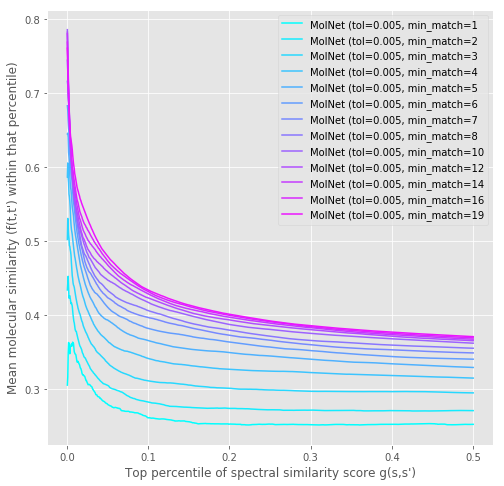

In [31]:
# Compare selection:
plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(8,8))
cmap = matplotlib.cm.get_cmap('cool') #('plasma') #('Spectral')

selection = [0,1,2,3,4,5,6,7,9,11,13,15,18]
N = len(selection)
for i, select in enumerate(selection):
    ref_score_cum = ref_score_cum_collection[select]
    plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_cum, 
             color=cmap(i/N), #color_sequence[i], 
             label="MolNet (tol=0.005, min_match="+str(select+1))

plt.legend()
plt.xlabel("Top percentile of spectral similarity score g(s,s')")
plt.ylabel("Mean molecular similarity (f(t,t') within that percentile)")
plt.savefig('Modcosine_min_match_comparison_rdkit_jaccard_191204.pdf')

In [34]:
np.save(os.path.join(PATH_COMPUTED, 's2v_uI_pos_ModCos_rdkit_jaccard_min_match_10.npy'), ref_score_cum_collection[9])
np.save(os.path.join(PATH_COMPUTED, 's2v_uI_pos_ModCos_rdkit_jaccard_min_match_14.npy'), ref_score_cum_collection[13])
np.save(os.path.join(PATH_COMPUTED, 's2v_uI_pos_ModCos_rdkit_jaccard_min_match_16.npy'), ref_score_cum_collection[15])

# Additional test of modified cosine score functions

In [4]:
import MS_similarity_classical as MS_sim_classic

### Now there is 3 ways to compute the modified cosine scores.
1. Greedy method (mostly taken from Simon)
2. Greedy method + some parts compiled using Numba.
3. More precise Hungarian algorithm + using Numba.

In [5]:
%%time
modcos_sim0, modcos_matches0 = MS_sim_classic.cosine_score_matrix(spectra[:1000], 
                  tol = 0.005, 
                  max_mz = 1000.0, 
                  min_intens = 0,
                  mass_shifting = True,
                  method='greedy', 
                  num_workers = 4,
                  filename = None, #'testing_molent_new.npy',
                  safety_points = None)

print('\n' + 40 * '-')

Calculate pairwise scores by  4 number of workers.
  Calculated MolNet for pair  968 -- 995 . (  100.0  % done).
----------------------------------------
Wall time: 3min 16s


In [6]:
%%time
modcos_sim_greedy, modcos_matches_greedy = MS_sim_classic.cosine_score_matrix(spectra[:1000], 
                  tol = 0.005,
                  max_mz = 1000.0, 
                  min_intens = 0,
                  mass_shifting = True,
                  method='greedy-numba', 
                  num_workers = 4,
                  filename = None, #'testing_molent_new.npy',
                  safety_points = None)

print('\n' + 40 * '-')

Calculate pairwise scores by  4 number of workers.
  Calculated MolNet for pair  968 -- 995 . (  100.0  % done).lculated MolNet for pair  20 -- 209 . (  4.0  % done). 24 -- 299 . (  4.8  % done). 377 . (  10.2  % done).769 . (  11.6  % done). Calculated MolNet for pair  61 -- 890 . (  12.0  % done).71 -- 555 . (  13.8  % done).. (  15.2  % done). % done).. (  19.4  % done).-- 625 . (  23.2  % done).-- 729 . (  26.0  % done). -- 730 . (  27.2  % done). -- 909 . (  36.8  % done). % done). -- 639 . (  44.6  % done).258 -- 410 . (  45.0  % done). -- 469 . (  48.8  % done).. (  53.4  % done).-- 627 . (  54.8  % done).429 . (  59.6  % done).376 -- 875 . (  61.2  % done). -- 770 . (  61.8  % done).535 . (  62.0  % done). 435 . (  65.0  % done).. (  67.8  % done). 451 -- 925 . (  70.0  % done).. (  71.6  % done).-- 574 . (  72.4  % done). 73.2  % done).  % done). 526 -- 600 . (  77.6  % done). . (  78.0  % done). Calculated MolNet for pair  552 -- 627 . (  80.0  % done).
----------------------

In [7]:
%%time
modcos_sim, modcos_matches = MS_sim_classic.cosine_score_matrix(spectra[:1000], 
                  tol = 0.005, 
                  max_mz = 1000.0, 
                  min_intens = 0,
                  mass_shifting = True,
                  method='hungarian', 
                  num_workers = 4,
                  filename = None, #'testing_molent_new.npy',
                  safety_points = None)

print('\n' + 40 * '-')

Calculate pairwise scores by  4 number of workers.
  Calculated MolNet for pair  968 -- 995 . (  100.0  % done).9 . (  8.0  % done). 127 . (  9.2  % done). . (  12.6  % done).67 -- 277 . (  13.0  % done). -- 700 . (  14.2  % done).14.4  % done). % done).655 . (  18.4  % done).98 -- 850 . (  18.8  % done). 103 -- 355 . (  19.6  % done). -- 785 . (  22.0  % done).. (  22.6  % done). 384 . (  24.2  % done). 132 -- 777 . (  24.8  % done). 25.4  % done). 452 . (  25.6  % done). % done).. (  30.4  % done). -- 364 . (  31.0  % done).180 -- 289 . (  32.8  % done). 192 -- 527 . (  34.8  % done).-- 305 . (  35.4  % done). 36.4  % done). 527 . (  37.2  % done). -- 365 . (  37.8  % done). 260 . (  41.2  % done). . (  43.4  % done).639 . (  44.6  % done). -- 410 . (  45.0  % done).266 -- 510 . (  46.2  % done). Calculated MolNet for pair  281 -- 620 . (  48.4  % done). 285 -- 754 . (  49.0  % done). % done).298 -- 550 . (  50.8  % done).-- 680 . (  54.0  % done).350 -- 424 . (  57.8  % done). Calcu

In [8]:
mat_diff = modcos_sim_greedy - modcos_sim0
mat_diff.max(), mat_diff.min()

NameError: name 'modcos_sim_greedy' is not defined

In [9]:
mat_diff = modcos_sim_greedy - modcos_sim
mat_diff.max(), mat_diff.min()

(2.120525977034049e-14, -0.0662486241177156)

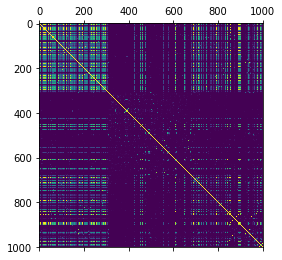

In [11]:
from matplotlib import pyplot as plt
plt.matshow(modcos_sim)

#### Check difference between greedy and hungarian computation:

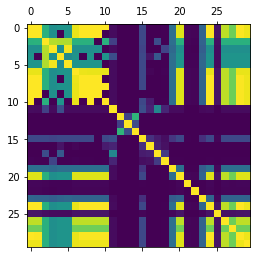

In [13]:
plt.matshow(modcos_sim0[:30,:30])

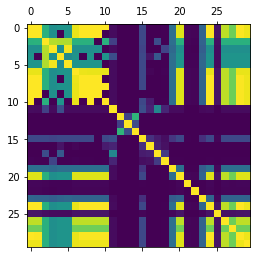

In [12]:
plt.matshow(modcos_sim_greedy[:30,:30])

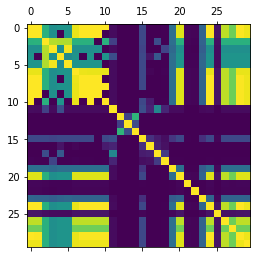

In [24]:
plt.matshow(modcos_sim[:30,:30])

In [15]:
mat_diff = modcos_sim_greedy - modcos_sim0
mat_diff.max(), mat_diff.min()

(0.9043544184552202, 0.0)

In [16]:
np.where(mat_diff > 0.9)

(array([221, 897], dtype=int64), array([897, 221], dtype=int64))

In [17]:
ID1, ID2 = 221, 897
max_mz = 1000.0
tol = 0.005
mass_shift = spectra[ID1].parent_mz - spectra[ID2].parent_mz
print(mass_shift)

spec1 = np.array(spectra[ID1].peaks, dtype=float)
spec1 = spec1[spec1[:,0] < max_mz,:]
spec2 = np.array(spectra[ID2].peaks, dtype=float)
spec2 = spec2[spec2[:,0] < max_mz,:]
#mass_shift = spectra[ID1].parent_mz - spectra[ID2].parent_mz

#MS_sim_classic.find_pairs(spec1, spec2, tol)
MS_sim_classic.cosine_score_greedy(spec1, 
                        spec2,
                        mass_shift,
                        tol, 
                        min_intens = 0,
                        use_numba = False)

217.171


(2.3282994584941852e-05,
 [(112, 5, 1.7059246489623038e-05), (115, 10, 8.686184847698088e-06)])

In [18]:
MS_sim_classic.find_pairs(spec1, spec2, tol, shift = mass_shift)

[(112, 5, 1.7059246489623038e-05), (115, 10, 8.686184847698088e-06)]

In [55]:
spec1[18:21,0], spec2[9:12,0] + mass_shift

(array([225.055695, 252.042999, 253.050598]),
 array([245.614145, 252.972726, 253.053354]))

In [19]:
#MS_sim_classic.find_pairs_numba(spec1, spec2, tol)
MS_sim_classic.cosine_score_greedy(spec1, 
                        spec2,
                        mass_shift,
                        tol, 
                        min_intens = 0,
                        use_numba = True)

(0.9043777014498052,
 [(116, 12, 1.0),
  (51, 5, 1.7059246489623038e-05),
  (101, 10, 8.686184847698088e-06)])

In [21]:
MS_sim_classic.find_pairs_numba(spec1, spec2, tol, shift = mass_shift)

[(51, 5, 1.7059246489623038e-05),
 (101, 10, 8.686184847698088e-06),
 (116, 12, 1.0)]

In [32]:
spec1[[116, 51, 101, 115],0], spec2[[12, 5, 10],0] + mass_shift

(array([341.211212, 295.205505, 323.2005  , 107.085503]),
 array([341.216212, 295.207034, 323.203578]))

In [23]:
np.abs(spec2[:,0] - spec1[51,0] + mass_shift)

array([2.7010594e+01, 2.6007386e+01, 2.4994763e+01, 9.9832510e+00,
       5.2860690e+00, 1.5290000e-03, 1.0096840e+00, 2.0172220e+00,
       1.0450190e+01, 1.8013217e+01, 2.7998073e+01, 4.3993701e+01,
       4.6010707e+01, 4.7012545e+01, 6.2005580e+01])